In [2]:
from triple_stream_data_utils import *

def _ndarray_to_npy_bytes(arr, allow_pickle=False):
    buf = io.BytesIO()
    # .npy format is versioned & stable; this avoids numpy's pickle reducers
    np.save(buf, arr, allow_pickle=allow_pickle)
    return buf.getvalue()

def _npy_bytes_to_ndarray(b, allow_pickle=False):
    buf = io.BytesIO(b)
    return np.load(buf, allow_pickle=allow_pickle)

def _encode_for_pickle(obj, allow_pickle_arrays=False):
    """
    Recursively convert ndarrays into a small marker dict with .npy bytes.
    Everything else is returned as-is (and will be pickled normally).
    """
    if isinstance(obj, np.ndarray):
        return {"__npy__": True, "data": _ndarray_to_npy_bytes(obj, allow_pickle=allow_pickle_arrays)}
    elif isinstance(obj, dict):
        return {k: _encode_for_pickle(v, allow_pickle_arrays) for k, v in obj.items()}
    elif isinstance(obj, (list, tuple)):
        t = type(obj)
        return t(_encode_for_pickle(v, allow_pickle_arrays) for v in obj)
    else:
        return obj

def _decode_after_unpickle(obj, allow_pickle_arrays=False):
    """
    Inverse of _encode_for_pickle: turn marker dicts back into ndarrays.
    """
    if isinstance(obj, dict):
        if obj.keys() == {"__npy__", "data"} and obj.get("__npy__") is True:
            return _npy_bytes_to_ndarray(obj["data"], allow_pickle=allow_pickle_arrays)
        else:
            return {k: _decode_after_unpickle(v, allow_pickle_arrays) for k, v in obj.items()}
    elif isinstance(obj, (list, tuple)):
        t = type(obj)
        return t(_decode_after_unpickle(v, allow_pickle_arrays) for v in obj)
    else:
        return obj

def load_compiled_dataset_pkl_bz2(dataset_pkl_bz2, *, allow_pickle_arrays=False):
    """
    Load a compiled dataset saved by compile_data_for_multiple_datasets_pkl().
    """
    assert dataset_pkl_bz2.endswith(".pkl.bz2"), "Dataset name must end with .pkl.bz2"
    compiled_data_path = dataset_pkl_bz2
    if not os.path.exists(compiled_data_path):
        raise FileNotFoundError(f"No compiled dataset found at {compiled_data_path}")

    with bz2.BZ2File(compiled_data_path, 'rb') as f:
        raw = pickle.load(f)
    return _decode_after_unpickle(raw, allow_pickle_arrays=allow_pickle_arrays)


Could not import fluidsynth. AUDIO rendering will not work.


In [3]:
# Make sure you've already ran python CompileStreamsAndFeatures.py

root = "data/triple_streams/split_2bars/compiled_data/"
all_pkl_bz2_files = [f for f in os.listdir(root) if f.endswith('.pkl.bz2')]

# Available Datasets
available_datasets_path = {
    all_pkl_bz2_file.split(".pkl.bz2")[0]: os.path.join(root, all_pkl_bz2_file) for all_pkl_bz2_file in all_pkl_bz2_files
}

available_datasets_path

{'lmd_drum_guitar_percussion_piano': 'data/triple_streams/split_2bars/compiled_data/lmd_drum_guitar_percussion_piano.pkl.bz2',
 'lmd_drum_guitar_percussive_piano': 'data/triple_streams/split_2bars/compiled_data/lmd_drum_guitar_percussive_piano.pkl.bz2',
 'lmd_bass_brass_guitar_piano': 'data/triple_streams/split_2bars/compiled_data/lmd_bass_brass_guitar_piano.pkl.bz2',
 'groove_midi_crash_hhclosed_hhopen_ride': 'data/triple_streams/split_2bars/compiled_data/groove_midi_crash_hhclosed_hhopen_ride.pkl.bz2',
 'lmd_bass_percussion_percussive_piano': 'data/triple_streams/split_2bars/compiled_data/lmd_bass_percussion_percussive_piano.pkl.bz2',
 'lmd_bass_drum_guitar_piano': 'data/triple_streams/split_2bars/compiled_data/lmd_bass_drum_guitar_piano.pkl.bz2',
 'groove_midi_hh_kick_snare_toms': 'data/triple_streams/split_2bars/compiled_data/groove_midi_hh_kick_snare_toms.pkl.bz2',
 'elbg_both_flattened_left_right': 'data/triple_streams/split_2bars/compiled_data/elbg_both_flattened_left_right.pkl.

In [9]:
dataset_tags = ["lmd_bass_drum_guitar_piano"]   # "lmd" is not included here
loaded_datasets = {}

for dataset_tag in dataset_tags:
    # load .pkl.bz2 file
    if dataset_tag in available_datasets_path:
        d_dict = load_compiled_dataset_pkl_bz2(available_datasets_path[dataset_tag])
        for key, val in d_dict.items():
            if key not in loaded_datasets:
                loaded_datasets[key] = []
            loaded_datasets[key].extend(val)

print(loaded_datasets.keys())

dict_keys(['input_hvos', 'output_hvos', 'flat_out_hvos', 'sample_id', 'collection', 'metadata', 'qpm', 'OF_Input Hamming', 'OF_Input Hamming Accent', 'OS1_OF Jaccard', 'OS2_OF Jaccard', 'OS3_OF Jaccard', 'pearson', 'cosine', 'euclidean_similarity', 'mae_similarity', 'dtw_similarity'])


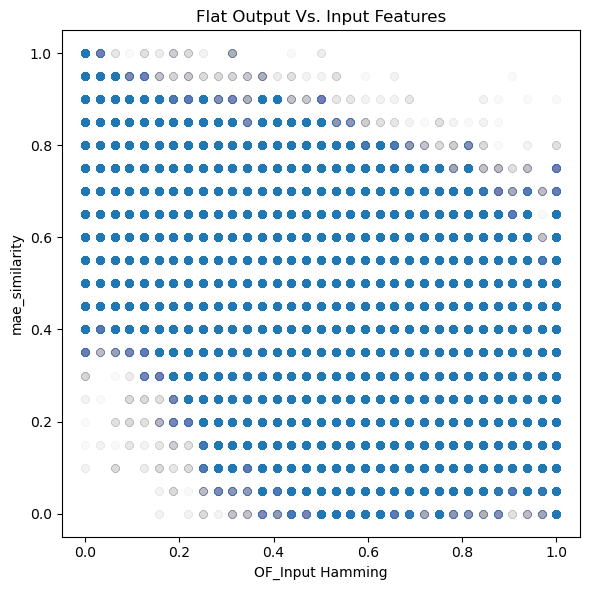

In [ ]:
feature1 = "OF_Input Hamming"
feature2 = "mae_similarity"
plot_scatter_distribution(
    feat1=loaded_datasets[feature1],
    feat2=loaded_datasets[feature2],
    xlabel=feature1,
    ylabel=feature2,
    title="Flat Output Vs. Input Features"
)
create_heatmap_histogram_from_lists(
    feat1=loaded_datasets[feature1],
    feat2=loaded_datasets[feature2],
    xlabel=feature1,
    ylabel=feature2,
    title="Flat Output Vs. Input Features"
)

In [8]:
# clip accents at 0.75
clipped_accents = [min(v, 0.75) for v in loaded_datasets["OF_Input Hamming Accent"]]

plot_scatter_distribution(
    feat1=loaded_datasets["OF_Input Hamming"],
    feat2=clipped_accents,
    xlabel="Hits Hamming",
    ylabel="Accented Hits Hamming",
    title="Flat Output Vs. Input Features"
)
create_heatmap_histogram_from_lists(
    feat1=loaded_datasets["OF_Input Hamming"],
    feat2=clipped_accents,
    xlabel="Hits Hamming",
    ylabel="Accented Hits Hamming",
    title="Flat Output Vs. Input Features",
    clip_counts_at=50000,
    saturate_colors_only=True
)


KeyError: 'OF_Input Hamming Accent'

In [ ]:
# sample_ix = 100 # for each sample 24 variations
# input_hvos = loaded_datasets["input_hvos"][sample_ix*24: ((sample_ix+1)*24)]
# output_hvos = loaded_datasets["output_hvos"][sample_ix*24: ((sample_ix+1)*24)]
# metadatas = loaded_datasets["metadata"][sample_ix*24: ((sample_ix+1)*24)]
# print(len(input_hvos), len(output_hvos), len(metadatas))
# print(loaded_datasets["OF_Input Hamming"][sample_ix*24: ((sample_ix+1)*24)])
# print(loaded_datasets["OF_Input Hamming Accent"][sample_ix*24: ((sample_ix+1)*24)])
# print(loaded_datasets["OS1_OF Jaccard"][sample_ix*24: ((sample_ix+1)*24)])
# print(loaded_datasets["OS2_OF Jaccard"][sample_ix*24: ((sample_ix+1)*24)])
# print(loaded_datasets["OS3_OF Jaccard"][sample_ix*24: ((sample_ix+1)*24)])
# create_multitab_from_HVO_Sequences(compile_into_list_of_hvo_seqs(input_hvos, output_hvos, metadatas, qpms=None))